# Reproducibility Report   
#### Import required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression

#### Data collected from the following link: https://apps.ams.usda.gov/pdp   
The data contains information of pesticides used on different commodities during the year 1994 to 2021

In [2]:
# read the data into a pandas dataframe
df = pd.read_csv('PDP Positive Detects 1994-2021.csv', low_memory=False)
df.head()

Sample ID Commod Pesticide Code  Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160    Chlorpyrifos          C   
1  CA0310280484AACA1      AA             83  O-Phenylphenol          I   
2  CA0311250391AACA1      AA             83  O-Phenylphenol          I   
3  FL0308220056AAFL1      AA            160    Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160    Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
1         0.0170  0.0100   M        MO       NaN       QV          H    O   
2         0.0170  0.0100   M        MO       NaN       QV          H    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   

  Extract  Determ EPA Tolerance (ppm)  
0     552     2.0                   5  
1     550     7.0                  NT  
2     550     7.0                  NT  
3     802    60.0                   5  
4     551    60.0                   5

## Preprocessing   
First we extracted the date from the the "sample ID" column which contains a unique sample identifer (combination of 2-letter Collection State code), 2-digit Year, 2-digit Month, 2-digit Day, 4-digit Collection Site code, 2-letter Commodity code, 3-character Analyzing Lab code, and optional 1-letter Source ID code   

In [3]:
# Create an empty list to store the extracted dates
dates = []

# Iterate through each row in the dataframe and extract the date from the "PDP Sample ID" column
for i in range(len(df)):
    sample_id = df.loc[i, "Sample ID"]
    year = sample_id[2:4]
    month = sample_id[4:6]
    day = sample_id[6:8]
    date = f"{year}-{month}-{day}"  # Assumes year is in the 21st century
    dates.append(date)

# Add the list of dates as a new column "Date" to the dataframe
df["Date"] = dates

More specifically we extracted the year and created a "Year" column

In [4]:
# Define a function to extract the year value from a date string and add the century prefix
def get_century_year(date_str):
    year = int(date_str[:2])
    if year > 90:
        century_prefix = "19"
    else:
        century_prefix = "20"
    return int(century_prefix + date_str[:2])

# Apply the get_century_year function to the date column to create the new "Year" column
df["Year"] = df["Date"].apply(get_century_year)

We then converted the "Concentration" column so all the units are in 'ppm' or (parts per million) so it would be accurate when compared to the EPA Tolerance column which is all in ppm

In [5]:
# Convert parts per trillion to parts per million where pp_ is 'T'
df.loc[df['pp_'] == 'T', 'Concentration'] = df['Concentration'] / 1000000
df.loc[df['pp_'] == 'T', 'LOD'] = df['LOD'] / 1000000
df.loc[df['pp_'] == 'T', 'pp_'] = 'M'

Next we excluded everything that was non-numeric in the 'EPA Tolerance (ppm)' column. Example of non-numeric data includes NT = no tolerance and AD = FDA action level

In [6]:
EPA = list(df["EPA Tolerance (ppm)"])
numbers = []
for i in EPA:
    if isinstance(i,str):
        # Find number or decimal in the column, exclude nan or otherwise:
        match = re.findall(r'\d+(?:\.\d+)?', i)
        if len(match) == 1:
            numbers.append(float(match[0]))
        elif len(match) == 2:
            numbers.append(float(match[0])/float(match[1]))
        else:
            numbers.append(np.nan)
    else:
        numbers.append(np.nan)
        
df["New EPA"] = numbers
df = df.dropna(subset=['New EPA'])

## Analysis   
Now that the preprocessing is finished, we then created a 'Percent of Threshold' column which compares the concentration to the EPA threshold. This helps us identify hazardous pesticides that exceeds the threshhold (higher that 100% means the concentration is greater than the EPA treshold).

In [7]:
df['Percent of Threshold'] = (df['Concentration'] / df['New EPA']) * 100
df.head()

Sample ID Commod Pesticide Code Pesticide Name Test Class  \
0  CA0307280363AACA1      AA            160   Chlorpyrifos          C   
3  FL0308220056AAFL1      AA            160   Chlorpyrifos          C   
4  MI0307280000AAFL1P     AA            160   Chlorpyrifos          C   
5  NY0307300009AAFL1      AA            160   Chlorpyrifos          C   
6  NY0307300228AAFL1      AA            160   Chlorpyrifos          C   

   Concentration     LOD pp_ Confirm 1 Confirm 2 Annotate Quantitate Mean  \
0         0.0250  0.0040   M         C         M      NaN          M    O   
3         0.0063  0.0038   M       NaN       NaN       Q           M    O   
4         0.0170  0.0038   M         D       NaN      NaN          M    O   
5         0.0063  0.0038   M         D       NaN        Q          M    O   
6         0.0063  0.0038   M         D       NaN        Q          M    O   

  Extract  Determ EPA Tolerance (ppm)      Date  Year  New EPA  \
0     552     2.0                   5  03-07-28  2003      5.0   
3     802    60.0                   5  03-08-22  2003      5.0   
4     551    60.0                   5  03-07-28  2003      5.0   
5     551     2.0                   5  03-07-30  2003      5.0   
6     551     2.0                   5  03-07-30  2003      5.0   

   Percent of Threshold  
0                 0.500  
3                 0.126  
4                 0.340  
5                 0.126  
6                 0.126

Next, we created a new table that groups the data by pesticide & year, and calculates the mean of the Percent of Threshold column. By doing so, we can compare the average harmfulness of each pesticide instead of pesticide/commodity

In [8]:
# Group the data by pesticide and year, and calculate the mean of the Percent of Threshold column
df_grouped = df.groupby(['Pesticide Name', 'Year'])['Percent of Threshold'].mean().reset_index()

# Print the new table
df_grouped.head()

Pesticide Name  Year  Percent of Threshold
0     1-Naphthol  1996              1.175000
1     1-Naphthol  1997              1.185417
2     1-Naphthol  1998              0.561333
3     1-Naphthol  1999              0.250000
4     1-Naphthol  2000              0.250000

## Future Prediction   
Using the new table and linear regression, we predicted the 'Percent of Threshold' for the next 5 years (2022 to 2026)

In [9]:
# Create a new dataframe to store the predicted values
df_predicted = pd.DataFrame(columns=['Pesticide ID', 'Year', 'Percent of Threshold'])

# Iterate through each pesticide
for pesticide_id in df_grouped['Pesticide Name'].unique():
    # Select the rows corresponding to the current pesticide
    df_current = df_grouped[df_grouped['Pesticide Name'] == pesticide_id]
    
    # Create the X and y arrays for linear regression
    X = df_current['Year'].values.reshape(-1, 1)
    y = df_current['Percent of Threshold'].values.reshape(-1, 1)
    
    # Create a new linear regression model
    model = LinearRegression()
    
    # Fit the model to the data
    model.fit(X, y)
    
    # Use the model to predict the next 5 years
    X_pred = np.array(range(2022, 2027)).reshape(-1, 1)
    y_pred = model.predict(X_pred)
    
    # Append the predicted values to the new dataframe
    df_predicted = df_predicted.append(pd.DataFrame({'Pesticide Name': pesticide_id,
                                                      'Year': range(2022, 2027),
                                                      'Percent of Threshold': y_pred.flatten()}))

# Print the predicted values
print(df_predicted)

   Pesticide ID  Year  Percent of Threshold Pesticide Name
0           NaN  2022              3.004436     1-Naphthol
1           NaN  2023              3.081258     1-Naphthol
2           NaN  2024              3.158080     1-Naphthol
3           NaN  2025              3.234902     1-Naphthol
4           NaN  2026              3.311724     1-Naphthol
..          ...   ...                   ...            ...
0           NaN  2022              1.136959       Zoxamide
1           NaN  2023              1.025358       Zoxamide
2           NaN  2024              0.913758       Zoxamide
3           NaN  2025              0.802157       Zoxamide
4           NaN  2026              0.690556       Zoxamide

[1610 rows x 4 columns]


## Line Graph   
Finaly we graphed the top 5 hazardous pesticides by using the predicted percent of threshold

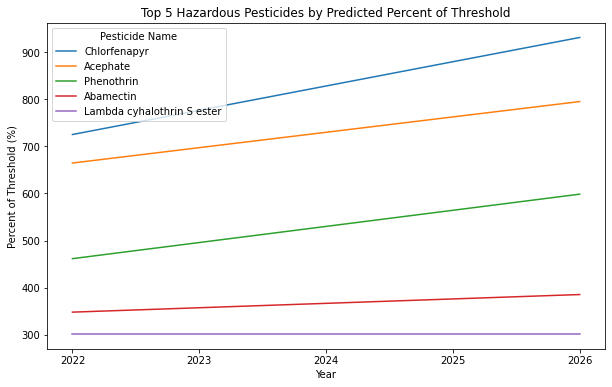

In [10]:
# Pivot the predicted data to make it easier to graph
df_predictions_pivot = df_predicted.pivot(index='Year', columns='Pesticide Name', values='Percent of Threshold')

# Create a line graph of the top 5 pesticides in 2027
top_pesticides_2027 = df_predictions_pivot.mean().sort_values(ascending=False).head(5).index.tolist()
df_predictions_pivot[top_pesticides_2027].plot(figsize=(10, 6))

# Set the title and axis labels
plt.title('Top 5 Hazardous Pesticides by Predicted Percent of Threshold')
plt.xlabel('Year')
plt.ylabel('Percent of Threshold (%)')
plt.xticks([2022,2023,2024,2025,2026])

# Show the graph
plt.show()

As we can see in the graph, the pesticide with the biggest impact on human and animal health in the next 5 years will be Chlorfenapyr as the percent of threshold is predicted to be the highest and incresing the most reapidly compared to the other pesticides

## Exporting the File   

In [11]:
plt.savefig('Top_5_Hazardous_Pesticides.png')

<Figure size 432x288 with 0 Axes>